In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
from datetime import datetime
import wandb

warnings.filterwarnings('ignore')


# DLinear Class:
* Preprocessing
* Feature Engineering
* Training
* Logging informative plots on WandB


Checking file paths...
✓ train.csv found
✓ test.csv found
✓ features.csv found
✓ stores.csv found
WALMART SALES PREDICTION PIPELINE

1. DATA PREPROCESSING
------------------------------
Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)
Merging and cleaning data...
After merging - Train shape: (421570, 16)
After merging - Test shape: (115064, 15)
Adding time features...
Adding holiday features...
Adding lag features...
Adding lag features...
Adding store/department features...
Adding markdown features...
Adding economic features...
Adding competitive features...
Final train shape: (421570, 90)
Final test shape: (115064, 90)

2. FEATURE SELECTION
------------------------------
Selecting best 30 features from 88 total features...
Selected features: ['Type', 'Size', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_12', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median']...
Selected 30 features:
 

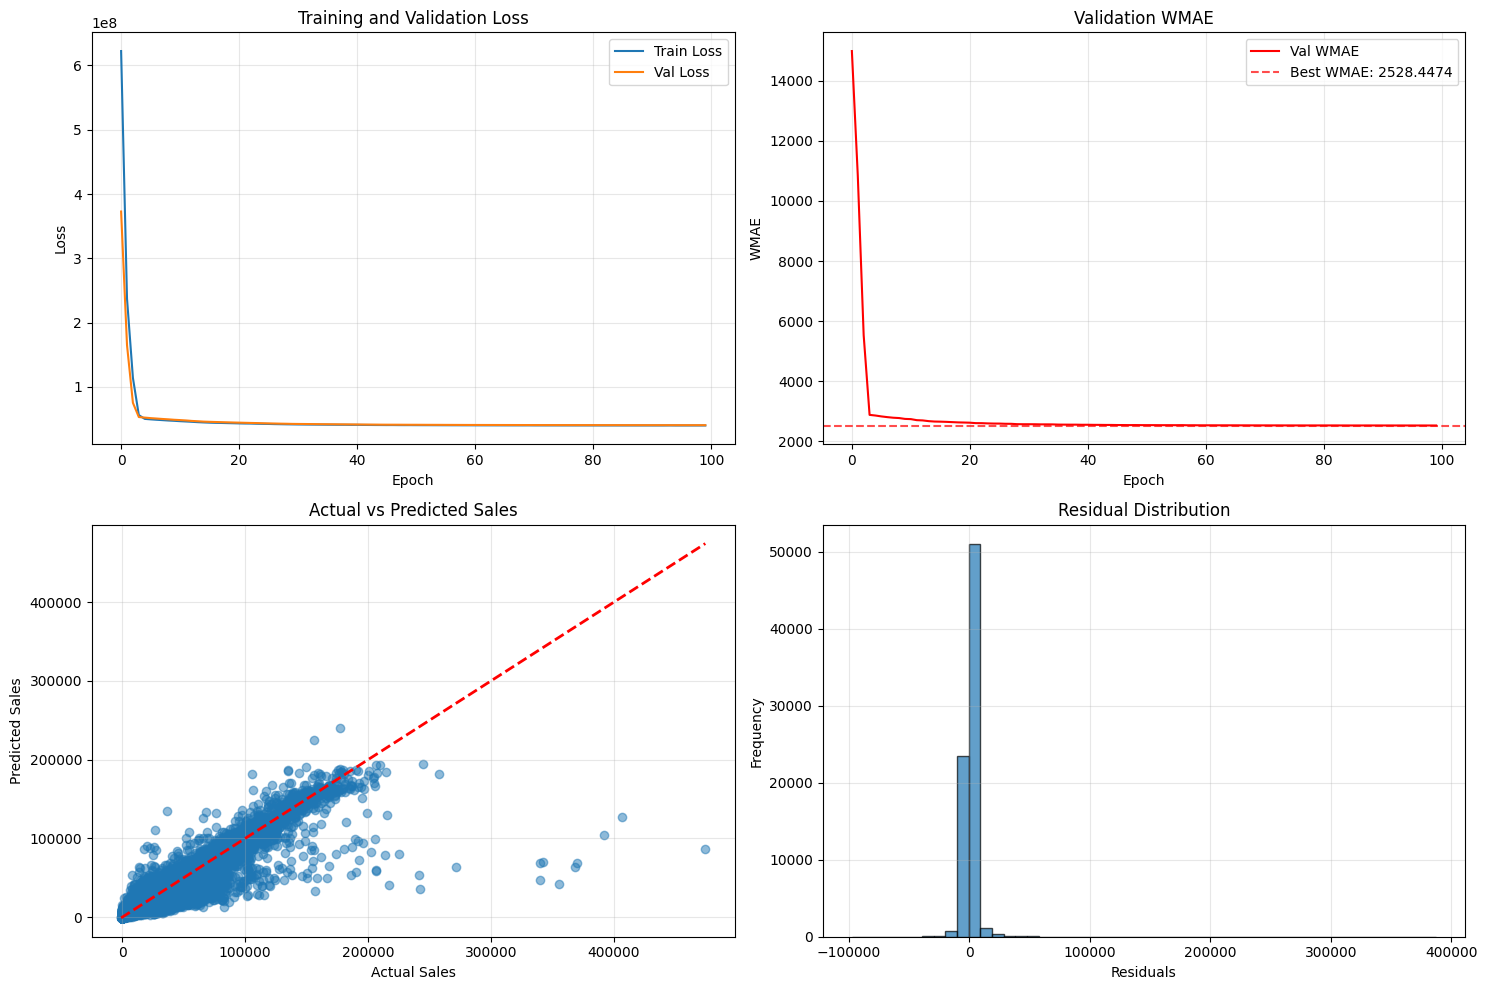


Training completed!
Best WMAE: 2528.4474
Final validation metrics:
  MAE: 2145.6456
  RMSE: 6356.4979
  R2: 0.9219

4. GENERATING PREDICTIONS
------------------------------
Preparing test sequences...
Error occurred: 'Weekly_Sales'


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Weekly_Sales'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-9-910916502.py", line 746, in main
    predictions = preprocessor.predict_test(test_df, selected_features)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-9-910916502.py", line 599, in predict_tes

best_wmae,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
final_best_wmae,▁
final_feature_count,▁
final_test_shape,▁
final_train_shape,▁
final_val_mae,▁
final_val_r2,▁
final_val_rmse,▁
learning_rate,████████▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,▁


In [ ]:
class DLinear(nn.Module):
    def __init__(self, input_dim, seq_length, pred_length=1):
        super(DLinear, self).__init__()
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.input_dim = input_dim

        self.decomposition = nn.AvgPool1d(kernel_size=25, stride=1, padding=12)

        self.trend_linear = nn.Linear(seq_length, pred_length)
        self.seasonal_linear = nn.Linear(seq_length, pred_length)

        self.trend_projection = nn.Linear(input_dim, 1)
        self.seasonal_projection = nn.Linear(input_dim, 1)

    def forward(self, x):
        batch_size, seq_len, features = x.shape

        x_trend = torch.zeros_like(x)
        x_seasonal = torch.zeros_like(x)

        for i in range(features):
            feature_data = x[:, :, i].unsqueeze(1)
            if feature_data.size(2) >= 25:
                trend = self.decomposition(feature_data)
                seasonal = feature_data - trend
            else:
                trend = feature_data
                seasonal = torch.zeros_like(feature_data)

            x_trend[:, :, i] = trend.squeeze(1)
            x_seasonal[:, :, i] = seasonal.squeeze(1)

        trend_proj = self.trend_projection(x_trend).squeeze(-1)
        seasonal_proj = self.seasonal_projection(x_seasonal).squeeze(-1)

        trend_out = self.trend_linear(trend_proj)
        seasonal_out = self.seasonal_linear(seasonal_proj)

        output = trend_out + seasonal_out
        return output.squeeze(-1)

class WalmartSalesPreprocessor:
    def __init__(self, wandb_project="walmart-sales-prediction"):
        self.label_encoders = {}
        self.feature_stats = {}
        self.wandb_project = wandb_project
        self.scaler = StandardScaler()
        self.model = None
        self.device = None

        wandb.init(
            project=self.wandb_project,
            name=f"walmart-sales-dlinear-{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            config={
                "model_type": "dlinear",
                "preprocessing_steps": [
                    "time_features", "holiday_features", "lag_features",
                    "store_dept_features", "markdown_features", "economic_features",
                    "competitive_features"
                ]
            }
        )

    def load_data(self, train_path, test_path, features_path, stores_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.features_df = pd.read_csv(features_path)
        self.stores_df = pd.read_csv(stores_path)

        print(f"Train shape: {self.train_df.shape}")
        print(f"Test shape: {self.test_df.shape}")
        print(f"Features shape: {self.features_df.shape}")
        print(f"Stores shape: {self.stores_df.shape}")

        return self.train_df, self.test_df, self.features_df, self.stores_df

    def merge_and_clean_data(self):
        for df in [self.train_df, self.test_df, self.features_df]:
            df['Date'] = pd.to_datetime(df['Date'])

        self.train_df = self.train_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
        self.test_df = self.test_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

        self.train_df = self.train_df.merge(self.stores_df, on='Store', how='left')
        self.test_df = self.test_df.merge(self.stores_df, on='Store', how='left')

        mark_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for col in mark_cols:
            self.train_df[col] = self.train_df[col].fillna(0)
            self.test_df[col] = self.test_df[col].fillna(0)

        for col in ['CPI', 'Unemployment']:
            self.train_df = self.train_df.sort_values(['Store', 'Date'])
            self.test_df = self.test_df.sort_values(['Store', 'Date'])

            self.train_df[col] = self.train_df.groupby('Store')[col].ffill().bfill()
            self.test_df[col] = self.test_df.groupby('Store')[col].ffill().bfill()

            if self.train_df[col].isna().any() or self.test_df[col].isna().any():
                overall_median = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(overall_median)
                self.test_df[col] = self.test_df[col].fillna(overall_median)

        self.train_df['IsHoliday'] = self.train_df['IsHoliday'].astype(int)
        self.test_df['IsHoliday'] = self.test_df['IsHoliday'].astype(int)

        self.label_encoders['Type'] = LabelEncoder()
        self.train_df['Type'] = self.label_encoders['Type'].fit_transform(self.train_df['Type'])
        self.test_df['Type'] = self.label_encoders['Type'].transform(self.test_df['Type'])

        print(f"After merging - Train shape: {self.train_df.shape}")
        print(f"After merging - Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def add_time_features(self):
        for df in [self.train_df, self.test_df]:
            df['Year'] = df['Date'].dt.year
            df['Month'] = df['Date'].dt.month
            df['Week'] = df['Date'].dt.isocalendar().week
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            df['Quarter'] = df['Date'].dt.quarter
            df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
            df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
            df['DayOfMonth'] = df['Date'].dt.day
            df['DayOfYear'] = df['Date'].dt.dayofyear

            df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
            df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
            df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
            df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
            df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
            df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

            df['IsWeekend'] = (df['DayOfWeek'].isin([5, 6])).astype(int)
            df['IsBackToSchool'] = ((df['Month'] == 8) | (df['Month'] == 9)).astype(int)
            df['IsHolidaySeason'] = ((df['Month'] == 11) | (df['Month'] == 12)).astype(int)
            df['IsNewYear'] = (df['Month'] == 1).astype(int)
            df['IsSummer'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)

        return self.train_df, self.test_df

    def add_holiday_features(self):
        super_bowl_dates = pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
        labor_day_dates = pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'])
        thanksgiving_dates = pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
        christmas_dates = pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])

        for df in [self.train_df, self.test_df]:
            df['IsSuperBowl'] = df['Date'].isin(super_bowl_dates).astype(int)
            df['IsLaborDay'] = df['Date'].isin(labor_day_dates).astype(int)
            df['IsThanksgiving'] = df['Date'].isin(thanksgiving_dates).astype(int)
            df['IsChristmas'] = df['Date'].isin(christmas_dates).astype(int)

        self.train_df = self._add_holiday_proximity(self.train_df)
        self.test_df = self._add_holiday_proximity(self.test_df)

        return self.train_df, self.test_df

    def _add_holiday_proximity(self, df):
        df = df.copy()
        df['HolidayProximity'] = 0

        holidays = df.loc[df['IsHoliday'] == 1, 'Date'].unique()

        for holiday in holidays:
            days_diff = (df['Date'] - holiday).dt.days

            mask_2weeks_before = (days_diff >= -14) & (days_diff < -7)
            mask_1week_before = (days_diff >= -7) & (days_diff < 0)
            mask_holiday = (days_diff == 0)
            mask_1week_after = (days_diff > 0) & (days_diff <= 7)
            mask_2weeks_after = (days_diff > 7) & (days_diff <= 14)

            df.loc[mask_2weeks_before, 'HolidayProximity'] = -2
            df.loc[mask_1week_before, 'HolidayProximity'] = -1
            df.loc[mask_holiday, 'HolidayProximity'] = 0
            df.loc[mask_1week_after, 'HolidayProximity'] = 1
            df.loc[mask_2weeks_after, 'HolidayProximity'] = 2

        return df

    def add_lag_features(self):
        print("Adding lag features...")

        self.train_df = self.train_df.sort_values(['Store', 'Dept', 'Date'])
        self.test_df = self.test_df.sort_values(['Store', 'Dept', 'Date'])

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.train_df[lag_col] = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

        last_train_sales = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].last().reset_index()
        last_train_sales.columns = ['Store', 'Dept', 'Last_Known_Sales']

        self.test_df = self.test_df.merge(last_train_sales, on=['Store', 'Dept'], how='left')

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.test_df[lag_col] = self.test_df['Last_Known_Sales']

        lag_cols = [f'Sales_Lag_{lag}' for lag in [1, 2, 4, 8, 12]]
        for col in lag_cols:
            self.train_df[col] = self.train_df.groupby(['Store', 'Dept'])[col].ffill()
            self.train_df[col] = self.train_df[col].fillna(self.train_df[col].median())
            if col in self.test_df.columns:
                self.test_df[col] = self.test_df[col].fillna(self.test_df[col].median())

        return self.train_df, self.test_df

    def add_store_dept_features(self):
        store_stats = self.train_df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_stats.columns = ['Store', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median', 'Store_Sales_Min', 'Store_Sales_Max']

        dept_stats = self.train_df.groupby('Dept')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        dept_stats.columns = ['Dept', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Median', 'Dept_Sales_Min', 'Dept_Sales_Max']

        store_dept_stats = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_dept_stats.columns = ['Store', 'Dept', 'StoreDept_Sales_Mean', 'StoreDept_Sales_Std', 'StoreDept_Sales_Median', 'StoreDept_Sales_Min', 'StoreDept_Sales_Max']

        holiday_stats = self.train_df[self.train_df['IsHoliday'] == 1].groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std']).reset_index()
        holiday_stats.columns = ['Store', 'Dept', 'Holiday_Sales_Mean', 'Holiday_Sales_Std']

        seasonal_stats = self.train_df.groupby(['Store', 'Dept', 'Quarter'])['Weekly_Sales'].mean().reset_index()
        seasonal_stats = seasonal_stats.pivot(index=['Store', 'Dept'], columns='Quarter', values='Weekly_Sales').reset_index()
        seasonal_stats.columns = ['Store', 'Dept', 'Q1_Sales_Mean', 'Q2_Sales_Mean', 'Q3_Sales_Mean', 'Q4_Sales_Mean']

        for stats_df in [store_stats, dept_stats, store_dept_stats, holiday_stats, seasonal_stats]:
            merge_cols = [col for col in stats_df.columns if col in ['Store', 'Dept']]
            self.train_df = self.train_df.merge(stats_df, on=merge_cols, how='left')
            self.test_df = self.test_df.merge(stats_df, on=merge_cols, how='left')

        stat_cols = [col for col in self.train_df.columns if any(x in col for x in ['_Mean', '_Std', '_Median', '_Min', '_Max', 'Holiday_', 'Q1_', 'Q2_', 'Q3_', 'Q4_'])]

        for col in stat_cols:
            if col in self.train_df.columns:
                fill_value = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(fill_value)
                self.test_df[col] = self.test_df[col].fillna(fill_value)

        return self.train_df, self.test_df

    def add_markdown_features(self):
        markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for df in [self.train_df, self.test_df]:
            df['Total_MarkDown'] = df[markdown_cols].sum(axis=1)
            df['Active_MarkDowns'] = (df[markdown_cols] > 0).sum(axis=1)
            df['Max_MarkDown'] = df[markdown_cols].max(axis=1)
            df['MarkDown_Intensity'] = df['Total_MarkDown'] / (df['Size'] + 1)

            df['MarkDown_per_Dept'] = df['Total_MarkDown'] / (df['Dept'] + 1)
            df['Has_MarkDown'] = (df['Total_MarkDown'] > 0).astype(int)

            for i, col in enumerate(markdown_cols, 1):
                df[f'MarkDown{i}_Ratio'] = df[col] / (df['Total_MarkDown'] + 1)

        return self.train_df, self.test_df

    def add_economic_features(self):
        for df in [self.train_df, self.test_df]:
            df['Economic_Health'] = df['CPI'] / (df['Unemployment'] + 0.1)
            df['Fuel_Impact'] = df['Fuel_Price'] / df['CPI']
            df['CPI_Normalized'] = df['CPI'] / df['CPI'].mean()
            df['Unemployment_Normalized'] = df['Unemployment'] / df['Unemployment'].mean()
            df['Fuel_Price_Normalized'] = df['Fuel_Price'] / df['Fuel_Price'].mean()

            df['CPI_Change'] = df.groupby('Store')['CPI'].pct_change().fillna(0)
            df['Unemployment_Change'] = df.groupby('Store')['Unemployment'].pct_change().fillna(0)
            df['Fuel_Price_Change'] = df.groupby('Store')['Fuel_Price'].pct_change().fillna(0)

        return self.train_df, self.test_df

    def add_competitive_features(self):
        self.train_df['Size_Rank'] = self.train_df.groupby('Date')['Size'].rank(pct=True)
        self.test_df['Size_Rank'] = self.test_df.groupby('Date')['Size'].rank(pct=True)

        store_type_counts = self.train_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.train_df = self.train_df.merge(store_type_counts, on=['Type', 'Date'], how='left')

        store_type_counts_test = self.test_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.test_df = self.test_df.merge(store_type_counts_test, on=['Type', 'Date'], how='left')

        self.train_df['Type_Concentration'] = self.train_df['Type_Count'] / self.train_df.groupby('Date')['Type_Count'].transform('sum')
        self.test_df['Type_Concentration'] = self.test_df['Type_Count'] / self.test_df.groupby('Date')['Type_Count'].transform('sum')

        dept_popularity = self.train_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.train_df = self.train_df.merge(dept_popularity, on=['Dept', 'Date'], how='left')

        dept_popularity_test = self.test_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.test_df = self.test_df.merge(dept_popularity_test, on=['Dept', 'Date'], how='left')

        return self.train_df, self.test_df

    def preprocess_complete(self, train_path, test_path, features_path, stores_path):
        print("Loading data...")
        self.load_data(train_path, test_path, features_path, stores_path)

        print("Merging and cleaning data...")
        self.merge_and_clean_data()

        print("Adding time features...")
        self.add_time_features()

        print("Adding holiday features...")
        self.add_holiday_features()

        print("Adding lag features...")
        self.add_lag_features()

        print("Adding store/department features...")
        self.add_store_dept_features()

        print("Adding markdown features...")
        self.add_markdown_features()

        print("Adding economic features...")
        self.add_economic_features()

        print("Adding competitive features...")
        self.add_competitive_features()

        print(f"Final train shape: {self.train_df.shape}")
        print(f"Final test shape: {self.test_df.shape}")

        wandb.log({
            "final_train_shape": self.train_df.shape[0],
            "final_test_shape": self.test_df.shape[0],
            "final_feature_count": self.train_df.shape[1]
        })

        return self.train_df, self.test_df

    def get_feature_columns(self):
        exclude_cols = ['Weekly_Sales', 'Date', 'Last_Known_Sales']
        feature_cols = [col for col in self.train_df.columns if col not in exclude_cols]
        return feature_cols

    def select_best_features(self, train_df, feature_cols, n_features=25):
        print(f"Selecting best {n_features} features from {len(feature_cols)} total features...")

        X = train_df[feature_cols].fillna(0)
        y = train_df['Weekly_Sales']

        selector = SelectKBest(score_func=f_regression, k=n_features)
        X_selected = selector.fit_transform(X, y)

        selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
        print(f"Selected features: {selected_features[:10]}...")

        return selected_features

    def prepare_sequences(self, df, feature_cols, seq_length=8):
        df_sorted = df.sort_values(['Store', 'Dept', 'Date'])

        sequences = []
        targets = []

        for (store, dept), group in df_sorted.groupby(['Store', 'Dept']):
            if len(group) < seq_length:
                continue

            group_features = group[feature_cols].fillna(0).values
            group_targets = group['Weekly_Sales'].values

            for i in range(len(group) - seq_length + 1):
                sequences.append(group_features[i:i + seq_length])
                targets.append(group_targets[i + seq_length - 1])

        return np.array(sequences), np.array(targets)

    def calculate_wmae(self, y_true, y_pred, is_holiday):
        weights = np.where(is_holiday, 5.0, 1.0)
        weighted_errors = weights * np.abs(y_true - y_pred)
        wmae = np.sum(weighted_errors) / np.sum(weights)
        return wmae

    def train_model(self, train_df, selected_features, seq_length=8, batch_size=128, epochs=50, lr=0.001):
        print("Preparing sequences for training...")

        X_seq, y_seq = self.prepare_sequences(train_df, selected_features, seq_length)

        print(f"Total sequences: {len(X_seq)}")
        print(f"Sequence shape: {X_seq.shape}")

        holiday_seq = []
        for (store, dept), group in train_df.groupby(['Store', 'Dept']):
            group_sorted = group.sort_values('Date')
            if len(group_sorted) >= seq_length:
                for i in range(len(group_sorted) - seq_length + 1):
                    holiday_seq.append(group_sorted.iloc[i + seq_length - 1]['IsHoliday'])

        holiday_seq = np.array(holiday_seq)

        X_train, X_val, y_train, y_val, holiday_train, holiday_val = train_test_split(
            X_seq, y_seq, holiday_seq, test_size=0.2, random_state=42
        )

        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
        X_train_scaled = X_train_scaled.reshape(X_train.shape)

        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
        X_val_scaled = X_val_scaled.reshape(X_val.shape)

        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_scaled),
            torch.FloatTensor(y_train)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val_scaled),
            torch.FloatTensor(y_val)
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        model = DLinear(
            input_dim=len(selected_features),
            seq_length=seq_length,
            pred_length=1
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

        train_losses = []
        val_losses = []
        val_wmaes = []
        best_wmae = float('inf')
        patience_counter = 0
        early_stopping_patience = 12

        print("Starting training...")
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            val_predictions = []
            val_actuals = []

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()

                    val_predictions.extend(outputs.cpu().numpy())
                    val_actuals.extend(batch_y.cpu().numpy())

            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            mae = mean_absolute_error(val_actuals, val_predictions)
            rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
            r2 = r2_score(val_actuals, val_predictions)

            wmae = self.calculate_wmae(
                np.array(val_actuals),
                np.array(val_predictions),
                holiday_val
            )
            val_wmaes.append(wmae)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, WMAE: {wmae:.4f}")

            scheduler.step()

            if wmae < best_wmae:
                best_wmae = wmae
                patience_counter = 0
                torch.save(model.state_dict(), 'best_dlinear_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_mae": mae,
                "val_rmse": rmse,
                "val_r2": r2,
                "val_wmae": wmae,
                "best_wmae": best_wmae,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        model.load_state_dict(torch.load('best_dlinear_model.pth'))
        self.model = model
        self.device = device

        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.plot(val_wmaes, label='Val WMAE', color='red')
        plt.axhline(y=best_wmae, color='red', linestyle='--', alpha=0.7, label=f'Best WMAE: {best_wmae:.4f}')
        plt.xlabel('Epoch')
        plt.ylabel('WMAE')
        plt.title('Validation WMAE')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        plt.scatter(val_actuals, val_predictions, alpha=0.5)
        plt.plot([min(val_actuals), max(val_actuals)], [min(val_actuals), max(val_actuals)], 'r--', lw=2)
        plt.xlabel('Actual Sales')
        plt.ylabel('Predicted Sales')
        plt.title('Actual vs Predicted Sales')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        residuals = np.array(val_actuals) - np.array(val_predictions)
        plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Residual Distribution')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        wandb.log({
            "final_best_wmae": best_wmae,
            "final_val_mae": mae,
            "final_val_rmse": rmse,
            "final_val_r2": r2,
            "total_epochs": epoch + 1
        })

        print(f"\nTraining completed!")
        print(f"Best WMAE: {best_wmae:.4f}")
        print(f"Final validation metrics:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2: {r2:.4f}")

        return model, best_wmae, selected_features

    def predict_test(self, test_df, selected_features, seq_length=8):
        print("Preparing test sequences...")

        if not hasattr(self, 'model') or self.model is None:
            raise ValueError("Model not trained yet. Please train the model first.")

        # Prepare test sequences
        X_test_seq, _ = self.prepare_sequences(test_df, selected_features, seq_length)

        if len(X_test_seq) == 0:
            print("No valid sequences found in test data. Using last known sales as fallback.")
            return test_df['Last_Known_Sales'].values

        # Scale test data
        X_test_scaled = self.scaler.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1]))
        X_test_scaled = X_test_scaled.reshape(X_test_seq.shape)

        # Make predictions
        self.model.eval()
        test_predictions = []

        with torch.no_grad():
            test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled))
            test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

            for batch_X, in test_loader:
                batch_X = batch_X.to(self.device)
                outputs = self.model(batch_X)
                test_predictions.extend(outputs.cpu().numpy())

        print(f"Generated {len(test_predictions)} predictions")
        return np.array(test_predictions)

    def create_submission(self, test_df, predictions, output_path='submission.csv'):
        submission_data = []
        pred_idx = 0

        for (store, dept), group in test_df.groupby(['Store', 'Dept']):
            group_sorted = group.sort_values('Date')

            for _, row in group_sorted.iterrows():
                if pred_idx < len(predictions):
                    prediction = max(0, predictions[pred_idx])
                    pred_idx += 1
                else:
                    prediction = row.get('Last_Known_Sales', 0)

                submission_data.append({
                    'Id': f"{row['Store']}_{row['Dept']}_{row['Date'].strftime('%Y-%m-%d')}",
                    'Weekly_Sales': prediction
                })

        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv(output_path, index=False)
        print(f"Submission saved to {output_path}")

        wandb.log({
            "submission_count": len(submission_df),
            "avg_prediction": submission_df['Weekly_Sales'].mean(),
            "min_prediction": submission_df['Weekly_Sales'].min(),
            "max_prediction": submission_df['Weekly_Sales'].max()
        })

        return submission_df

    def __del__(self):
        try:
            wandb.finish()
        except:
            pass

def main(train_path=None, test_path=None, features_path=None, stores_path=None):
    # Initialize preprocessor
    preprocessor = WalmartSalesPreprocessor(wandb_project="walmart-sales-dlinear")
    if train_path is None:
        train_path = '/content/drive/MyDrive/ML/final/train.csv'
    if test_path is None:
        train_path = '/content/drive/MyDrive/ML/final/test.csv'
    if features_path is None:
        train_path = '/content/drive/MyDrive/ML/final/features.csv'
    if stores_path is None:
        train_path = '/content/drive/MyDrive/ML/final/stores.csv'

    import os
    file_paths = {
        'train': train_path,
        'test': test_path,
        'features': features_path,
        'stores': stores_path
    }

    print("Checking file paths...")
    for name, path in file_paths.items():
        if not os.path.exists(path):
            print(f"Warning: {name} file not found at {path}")
            print("Please ensure all CSV files are in the correct location.")
            return
        else:
            print(f"✓ {name}.csv found")

    try:
        print("="*50)
        print("WALMART SALES PREDICTION PIPELINE")
        print("="*50)

        print("\n1. DATA PREPROCESSING")
        print("-" * 30)
        train_df, test_df = preprocessor.preprocess_complete(
            train_path, test_path, features_path, stores_path
        )

        print("\n2. FEATURE SELECTION")
        print("-" * 30)
        feature_cols = preprocessor.get_feature_columns()
        selected_features = preprocessor.select_best_features(
            train_df, feature_cols, n_features=30
        )

        print(f"Selected {len(selected_features)} features:")
        for i, feature in enumerate(selected_features):
            print(f"  {i+1:2d}. {feature}")

        print("\n3. MODEL TRAINING")
        print("-" * 30)
        model, best_wmae, _ = preprocessor.train_model(
            train_df,
            selected_features,
            seq_length=12,
            batch_size=128,
            epochs=100,
            lr=0.003
        )

        print("\n4. GENERATING PREDICTIONS")
        print("-" * 30)
        predictions = preprocessor.predict_test(test_df, selected_features)

        print("\n5. CREATING SUBMISSION")
        print("-" * 30)
        submission_df = preprocessor.create_submission(
            test_df, predictions, 'walmart_sales_submission.csv'
        )

        print("\n" + "="*50)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*50)
        print(f"Best WMAE achieved: {best_wmae:.4f}")
        print(f"Total predictions: {len(predictions)}")
        print(f"Submission file: walmart_sales_submission.csv")
        print(f"Average predicted sales: ${submission_df['Weekly_Sales'].mean():.2f}")
        print(f"Prediction range: ${submission_df['Weekly_Sales'].min():.2f} - ${submission_df['Weekly_Sales'].max():.2f}")

        print("\nSample predictions:")
        print(submission_df.head(10))

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

    finally:
        try:
            wandb.finish()
        except:
            pass


if __name__ == "__main__":
    main(
        train_path = '/content/drive/MyDrive/ML/final/train.csv',
        test_path = '/content/drive/MyDrive/ML/final/test.csv',
        features_path = '/content/drive/MyDrive/ML/final/features.csv',
        stores_path = '/content/drive/MyDrive/ML/final/stores.csv'
    )

